# Analysing Data

This notebook should aid in providing a linear step-by-step walkthrough of how I performed the analysis.

## Visualizing the Simulated Track

Firstly, we want to see what our simulated tracks look like.

In [1]:
# importing the conversion stuff
from conversions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

RAW_DATA_PATH = "../../data/tracks/" # fill this in please

For now we have one single track. We're going to look at just that.

          x         y         z
0 -0.238980 -0.082596 -0.035731
1 -0.238980 -0.082596 -0.035731
2 -0.238980 -0.082596 -0.035732
3 -0.238979 -0.082596 -0.035732
4 -0.238979 -0.082596 -0.035732


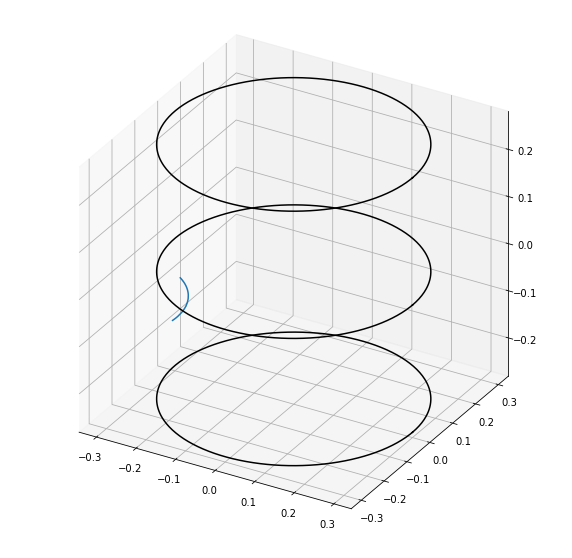

In [2]:
track = pd.read_csv(f"{RAW_DATA_PATH}simPosData-0.csv")
print(track.head())


# setting up the 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

ax.plot(track.x, track.y, track.z)

par_t = np.linspace(0,2*np.pi,360)
ax.plot(0.3*np.cos(par_t),0.3*np.sin(par_t),0.27,'k')
ax.plot(0.3*np.cos(par_t),0.3*np.sin(par_t),0,'k')
ax.plot(0.3*np.cos(par_t),0.3*np.sin(par_t),-0.27,'k')

plt.show()

Now the above thing doesn't have a long enough track, and in fact this does not intersect any of the vanes.
So what we're going to do now is actually produce the Detector Dataset and how many counts there are. If there are less than 5 datapoints, this entire dataset is discarded.

Now we're going to generate 20 tracks and plot them.

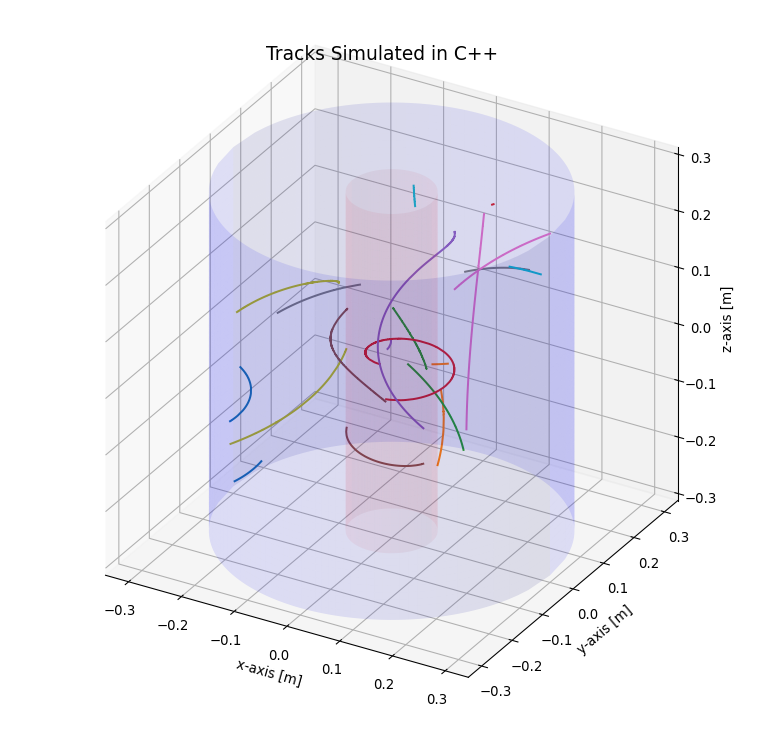

In [8]:
import glob # to get filenames

fig = plt.figure(figsize=(10,10),dpi=96)
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_zlabel("z-axis [m]")


det_x=np.linspace(-0.3, 0.3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt((0.3**2)-Xc**2)

# outerwall
ax.plot_surface(Xc, Yc, Zc, color='b',alpha=0.1)
ax.plot_surface(Xc, -Yc, Zc, color='b',alpha=0.1)
# innerwall

det_x=np.linspace(-75.5e-3, 75.5e-3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt(((75.5e-3)**2)-Xc**2)
ax.plot_surface(Xc, Yc, Zc, color='r',alpha=0.05)
ax.plot_surface(Xc, -Yc, Zc, color='r',alpha=0.05)
ax.set_title("Tracks Simulated in C++", fontsize=14)

for trackname in glob.glob(f"{RAW_DATA_PATH}simPos*"):
    track = pd.read_csv(trackname)
    ax.plot(track.x, track.y, track.z)

plt.savefig("plots/simulated-tracks-n20.png")
plt.show()

# Generating Detector Dataset

Now, we want to pass these simulated tracks though the detector and extract the data from it. This is cylindrical coordinates. To do so, we need to use the `Detector` class that I made for this step in the process.

In [10]:
from detector import * # importing all detector assets

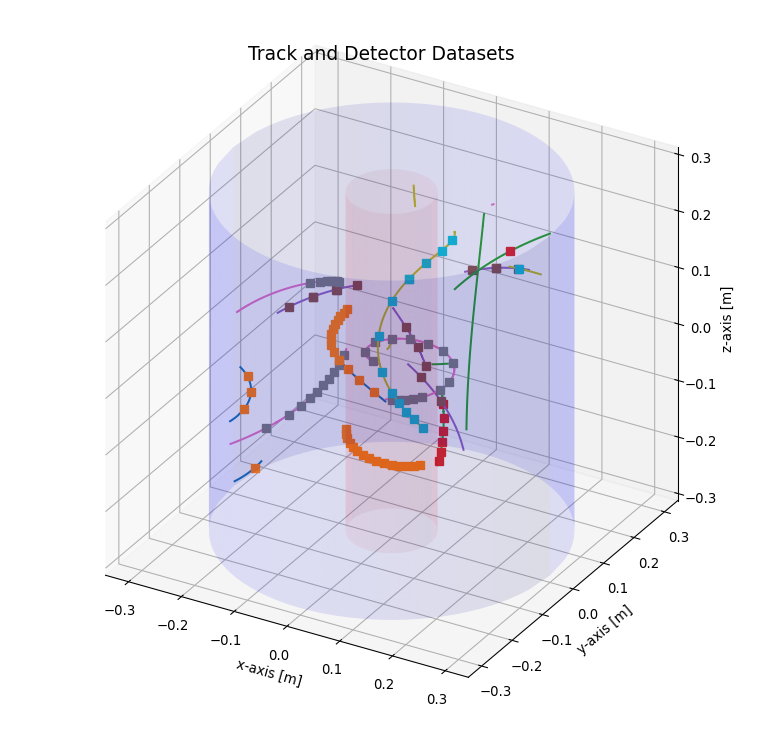

In [14]:
fig = plt.figure(figsize=(10,10),dpi=96)
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_zlabel("z-axis [m]")

det_x=np.linspace(-0.3, 0.3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt((0.3**2)-Xc**2)

# outerwall
ax.plot_surface(Xc, Yc, Zc, color='b',alpha=0.1)
ax.plot_surface(Xc, -Yc, Zc, color='b',alpha=0.1)
# innerwall

det_x=np.linspace(-75.5e-3, 75.5e-3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt(((75.5e-3)**2)-Xc**2)
ax.plot_surface(Xc, Yc, Zc, color='r',alpha=0.05)
ax.plot_surface(Xc, -Yc, Zc, color='r',alpha=0.05)
ax.set_title("Track and Detector Datasets", fontsize=14)

for trackname in glob.glob(f"{RAW_DATA_PATH}simPos*"):
    muse = Detector() # initializing the detector
    track = pd.read_csv(trackname) # importing the file
    track_cyl = cart2cyl(track) # converting the data from cartesian to cylindrical
    muse.setHits(track_cyl) # setting the hits on the detector
    data_track = muse.dataSet() # extracting the data from the detector (later saved)
    
    data_track_cart = cyl2cart(data_track)
    # plotting the actual track
    ax.plot(track.x, track.y, track.z)
    # plotting the detector data
    ax.plot(data_track_cart.x, data_track_cart.y, data_track_cart.z, 's')

plt.savefig("plots/detector-hits-n20")
plt.show()
    
    

Now that we have visualized these things, we are going to run through these detectors one more time. Then we will check how many hits each track produces. If the number of hits is below 5, then we reject the track entirely. If the dataset passes, then we actually _save_ the Detector Dataset (in a .h5 format for faster loadtimes and smaller memory occupation) in a different folder.

This step is called the **viability filter**.

In [15]:
for trackname in glob.glob(f"{RAW_DATA_PATH}simPos*"):
    muse = Detector() # initializing the detector
    track = pd.read_csv(trackname) # importing the file
    track_cyl = cart2cyl(track) # converting the data from cartesian to cylindrical
    muse.setHits(track_cyl) # setting the hits on the detector
    data_track = muse.dataSet() # extracting the data from the detector (later saved)
    
    if data_track.shape[0] >= 5 :
        # if the number of hits is greater than 5, then
        data_track.to_hdf(f"{RAW_DATA_PATH}/viable/track-{trackname[-5:-4]}.h5", 'track')

And just to visualize the viable tracks, we can access those files and load them up and plot them.

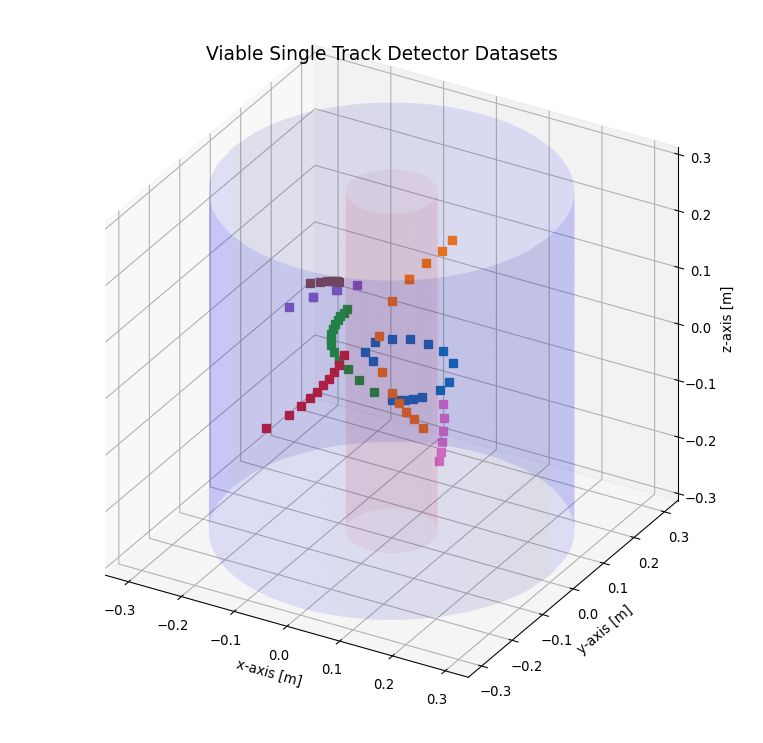

In [18]:
fig = plt.figure(figsize=(10,10),dpi=96)
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_zlabel("z-axis [m]")

det_x=np.linspace(-0.3, 0.3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt((0.3**2)-Xc**2)

# outerwall
ax.plot_surface(Xc, Yc, Zc, color='b',alpha=0.1)
ax.plot_surface(Xc, -Yc, Zc, color='b',alpha=0.1)
# innerwall

det_x=np.linspace(-75.5e-3, 75.5e-3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt(((75.5e-3)**2)-Xc**2)
ax.plot_surface(Xc, Yc, Zc, color='r',alpha=0.05)
ax.plot_surface(Xc, -Yc, Zc, color='r',alpha=0.05)

ax.set_title("Viable Single Track Detector Datasets", fontsize=14)

for trackname in glob.glob(f"{RAW_DATA_PATH}/viable/track*"):
    track = pd.read_hdf(trackname)
    data = cyl2cart(track)
    
    ax.plot(data.x, data.y, data.z,'s')

plt.savefig('plots/viable-hits.png')
plt.show()
    

# Producing 100 viable tracks

We got 7 viable STDDs after simulating 20 tracks. Therefore, as a very rough estimate, we need to produce 286 tracks to get 100 viable STDDs. To keep things a bit separate, this is going to be done in a separate folder called `tracks100`.

All of the above will now we done, with the final plot revealing the 100 STDDs.

100 number of viable tracks found.


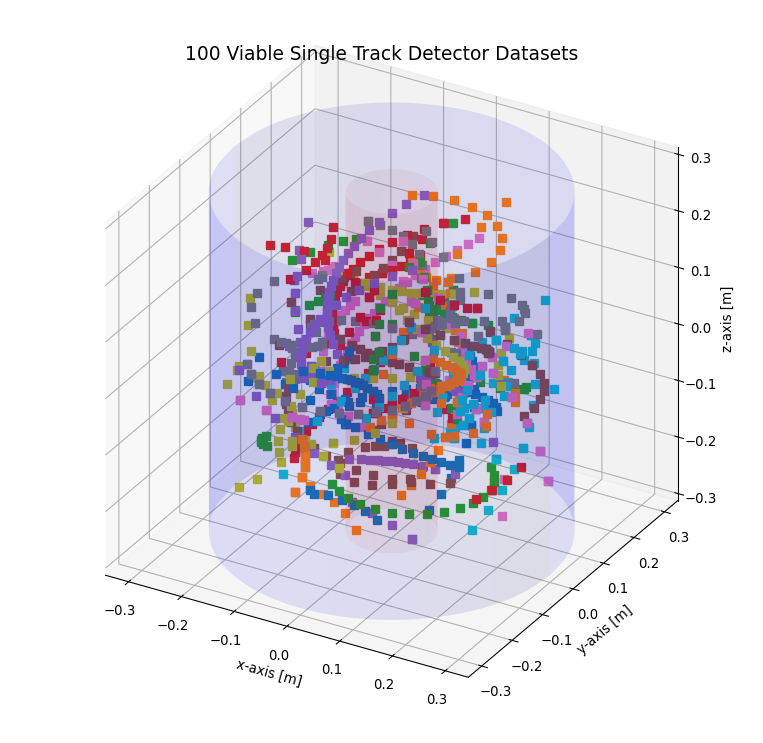

In [24]:
# importing the conversion stuff
from conversions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

RAW_DATA_PATH = "../../data/tracks100/" # fill this in please

# getting the Detector Dataset
viable_counter = 1
for trackname in glob.glob(f"{RAW_DATA_PATH}simPos*"):
    muse = Detector() # initializing the detector
    track = pd.read_csv(trackname) # importing the file
    track_cyl = cart2cyl(track) # converting the data from cartesian to cylindrical
    muse.setHits(track_cyl) # setting the hits on the detector
    data_track = muse.dataSet() # extracting the data from the detector (later saved)
    
    if data_track.shape[0] >= 5 :
        # if the number of hits is greater than 5, then save STDD\
        viable_counter += 1
        data_track.to_hdf(f"{RAW_DATA_PATH}/viable/track-{trackname[trackname.rfind('-')+1:trackname.rfind('.')]}.h5", 'track')
    
    if viable_counter == 100: # if we have 100 viable tracks, stop.
        break

# plotting the remaining tracks

fig = plt.figure(figsize=(10,10),dpi=96)
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_zlabel("z-axis [m]")

det_x=np.linspace(-0.3, 0.3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt((0.3**2)-Xc**2)

# outerwall
ax.plot_surface(Xc, Yc, Zc, color='b',alpha=0.1)
ax.plot_surface(Xc, -Yc, Zc, color='b',alpha=0.1)
# innerwall

det_x=np.linspace(-75.5e-3, 75.5e-3, 100)
det_z=np.linspace(-0.3, 0.3, 100)
Xc, Zc=np.meshgrid(det_x, det_z)
Yc = np.sqrt(((75.5e-3)**2)-Xc**2)
ax.plot_surface(Xc, Yc, Zc, color='r',alpha=0.05)
ax.plot_surface(Xc, -Yc, Zc, color='r',alpha=0.05)

ax.set_title("100 Viable Single Track Detector Datasets", fontsize=14)

for trackname in glob.glob(f"{RAW_DATA_PATH}/viable/track*"):
    track = pd.read_hdf(trackname)
    data = cyl2cart(track)
    
    ax.plot(data.x, data.y, data.z,'s')
print(f"{viable_counter} number of viable tracks found.")
plt.savefig('plots/viable-hits-n100.png')
plt.show()

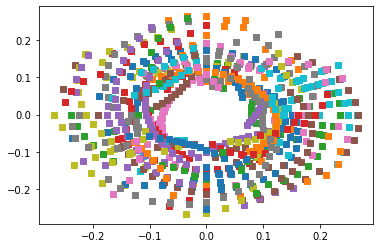

In [25]:
# looking from the top (so plotting only r and phi)

for trackname in glob.glob(f"{RAW_DATA_PATH}/viable/track*"):
    track = pd.read_hdf(trackname)
    data = cyl2cart(track)
    
    plt.plot(data.x, data.y,'s')
plt.show()

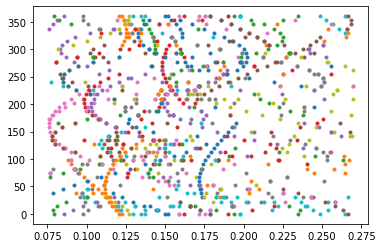

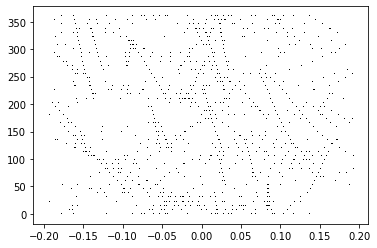

In [35]:
for trackname in glob.glob(f"{RAW_DATA_PATH}/viable/track*"):
    track = pd.read_hdf(trackname)
    plt.plot(track.r, track.phi,'.')
plt.show()
for trackname in glob.glob(f"{RAW_DATA_PATH}/viable/track*"):
    track = pd.read_hdf(trackname)
    plt.plot(track.z, track.phi,',k')
plt.show()

# Reduced Dimensionality Approach

Given that the full 3D problem is a bit much for moi, let's remove the z-axis and see what's going on. We will represent the pixel array as a 2D image made of pixels.

In [10]:
from conversions import *
from detector import * 
import glob
import matplotlib.pyplot as plt

In [52]:
# firstly, let's look at just 20 tracks to test the feasibility of this operation

muse = Detector() # initializing the detector

for trackname in glob.glob(f"{RAW_DATA_PATH}../tracks100/viable/track*"):
    track = pd.read_hdf(trackname) # importing the file
    muse.setHits(track) # setting the hits on the detector
data_track = muse.dataSet() # extracting the data from the detector (later saved)
musePixels = muse.dataDump() # the raw pixel arrays where 1 denotes a hit and 0 denotes unhit

In [92]:
def reduceDimensionality(pixelArray3d, args='rz'):
    """
    A function that will return a reduced 2D based on the arguments:
        1. 'rz' : Collapses the phi dimension by adding all of the vanes using phi as an index
        2. 'rp' : Collapses the z dimension by adding the vanes using z as an index
        3. 'zp' : Collapses the r dimension by adding the vanes using r as an index
    
    Return values : 2D reduced array
    """
    
    if args=='rz':
        # r-z case
        return sum(pixelArray3d)
    elif args=='rp':
        # r-phi case
        return np.array([sum(vane) for vane in pixelArray3d])
    elif args=='zp':
        # z-phi case
        return np.array([sum(vane.T) for vane in pixelArray3d])
    else:
        # default case
        print("Error in argument, using 'rz' option")
        return reduceDimensionality(pixelArray3d, 'rz')


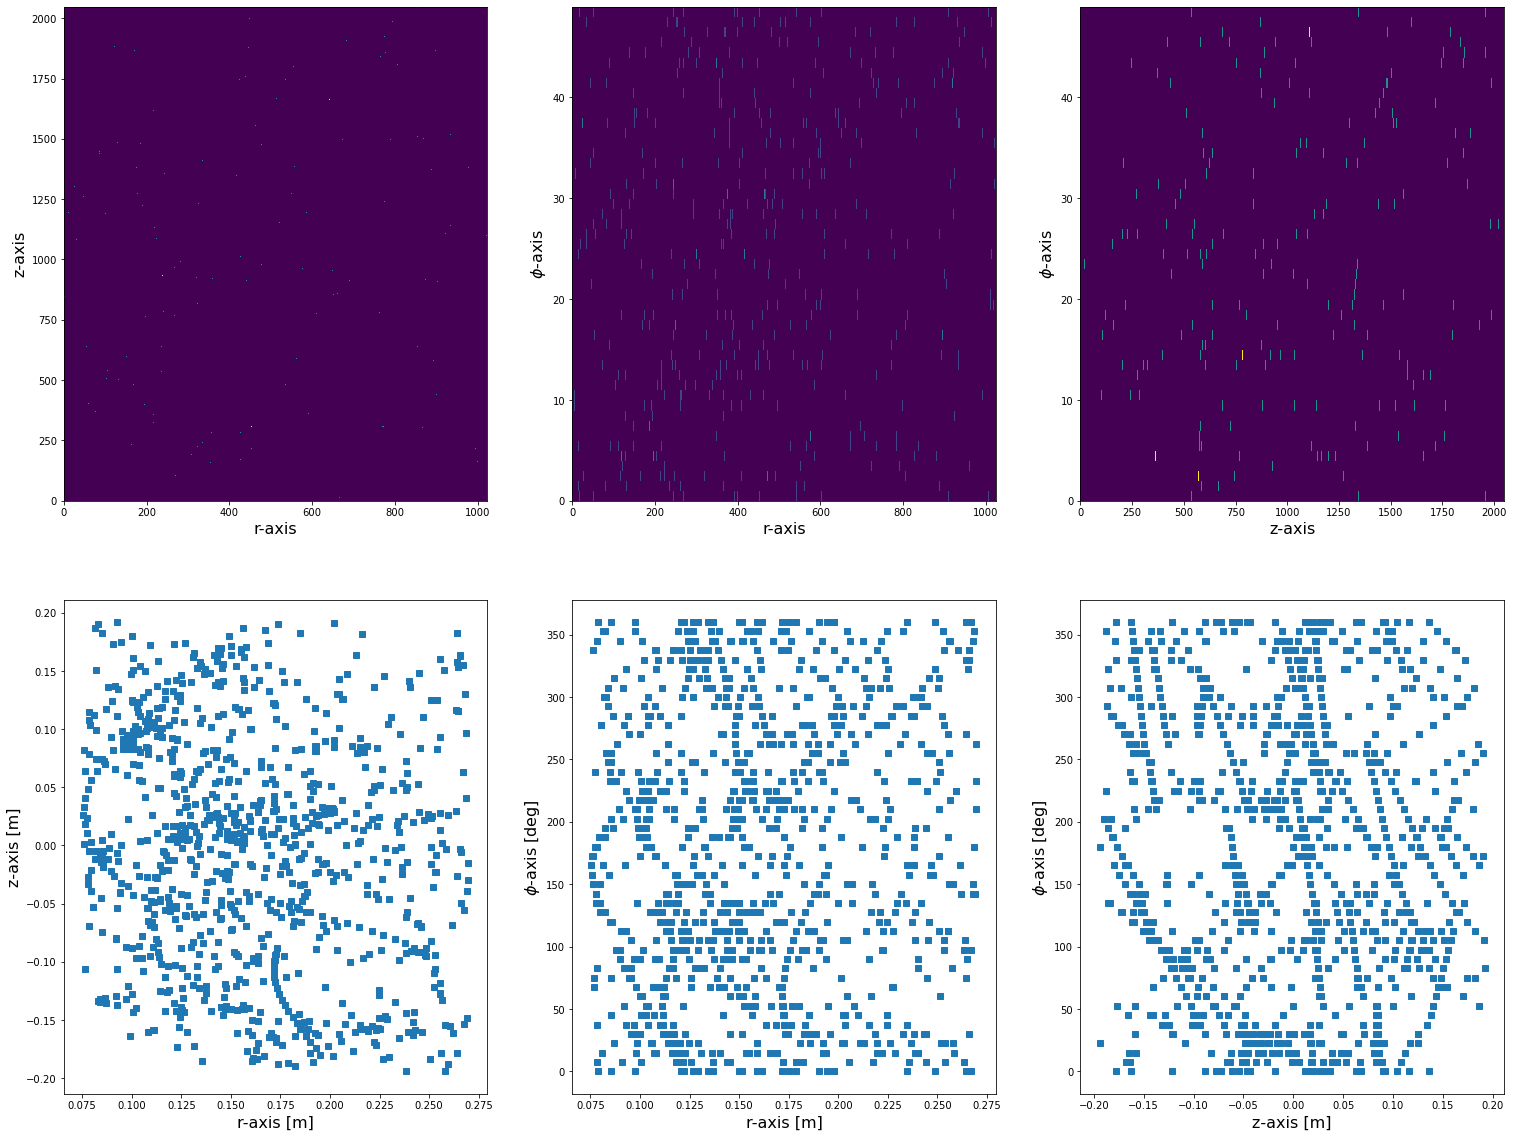

In [136]:
fig, axs = plt.subplots(2,3,figsize=(10,20))
plt.subplots_adjust(left=-1, right=1)
#plt.suptitle("Reduced pixel arrays",fontsize=20)
for i,opt in enumerate(['rz','rp','zp']):
    c = axs[0,i].pcolormesh(reduceDimensionality(musePixels,opt))
    if i==0:
        axs[0,i].set_xlabel('r-axis',fontsize=16)
        axs[0,i].set_ylabel('z-axis',fontsize=16)
    elif i==1:
        axs[0,i].set_xlabel('r-axis',fontsize=16)
        axs[0,i].set_ylabel('$\phi$-axis',fontsize=16)
    else:
        axs[0,i].set_xlabel('z-axis',fontsize=16)
        axs[0,i].set_ylabel('$\phi$-axis',fontsize=16)

axs[1,0].plot(data_track.r,data_track.z,'s')
axs[1,1].plot(data_track.r,data_track.phi,'s')
axs[1,2].plot(data_track.z,data_track.phi,'s')

for i in range(3):
    if i==0:
        axs[1,i].set_xlabel('r-axis [m]',fontsize=16)
        axs[1,i].set_ylabel('z-axis [m]',fontsize=16)
    elif i==1:
        axs[1,i].set_xlabel('r-axis [m]',fontsize=16)
        axs[1,i].set_ylabel('$\phi$-axis [deg]',fontsize=16)
    else:
        axs[1,i].set_xlabel('z-axis [m]',fontsize=16)
        axs[1,i].set_ylabel('$\phi$-axis [deg]',fontsize=16)
        
plt.savefig("plots/reduced-pixel-arrays.png",bbox_inches='tight')
plt.show()

# Retrying STEVE

Now that we have a dataset that has viable tracks, we can use STEVE to see how well it can perform.

ModuleNotFoundError: No module named 'keras'